In [2]:
#=== DOWNLOAD MODULES FIRST!! ===
!pip install iso3166
!pip install python-iso639


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached python_iso639-2025.11.16-py3-none-any.whl.metadata (15 kB)
Using cached python_iso639-2025.11.16-py3-none-any.whl (167 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


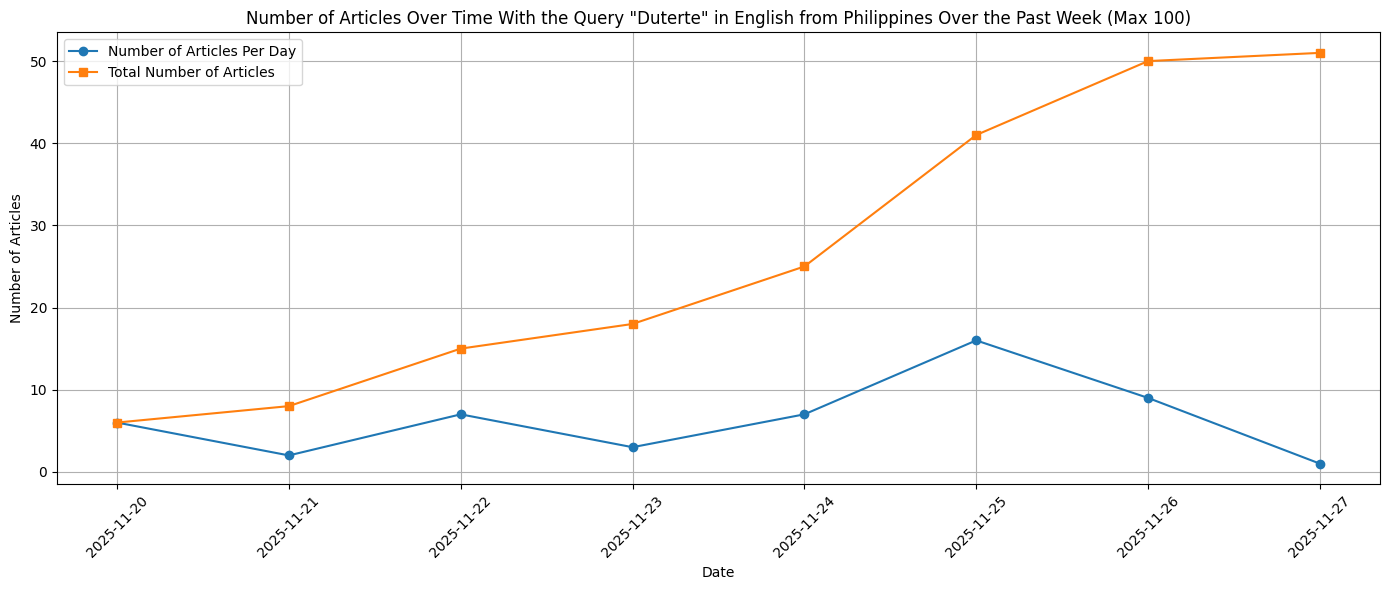

In [9]:
import requests
from iso3166 import countries
import iso639
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#=== LISTS AND DICTIONARIES OF COUNTRY AND LANGUAGE CODES ===
country_dict = {country.name.title(): country.alpha2.lower() for country in countries}
country_list = sorted([country.name.title() for country in countries])
language_dict = {language.name.title(): language.part1 for language in iso639.ALL_LANGUAGES if language.part1 is not None}
language_list = sorted([language.name.title() for language in iso639.ALL_LANGUAGES if language.part1 is not None])

#=== API PARAMETERS ===
API_KEY = "47fe05de29944f4dae1a1702cd37b38b"
BASE_URL = "https://api.worldnewsapi.com/search-news"

#=== API CALLS ===
def get_week_results(query: str, language: str | None = None, country: str | None = None):
    params = {
        "api-key" : API_KEY,
        "text" : f"\"{query.strip()}\"",
        "text-match-indexes" : "title,content",
        "number": "100",
        "earliest-publish-date": (datetime.today() - timedelta(weeks=1)).strftime("%Y-%m-%d")
    }

    if language is not None:
        params["language"] = language.lower()

    if country is not None:
        params["source-country"] = country.lower()


    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception("Error fetching data. Please check your connection.")

#=== SEARCH FUNCTION
def search_news():
    data = lang_code = country_code = None
    choice = input("Q=Quick Search, S=Specific Search: ")
    if choice.lower() == "q":
        query = input("Type in your query: ")
    elif choice.lower() == "s":
        query = input("Type in your query: ")

        country_code = None
        lang_code = None

        isCountry = False
        while not isCountry:
            country = input("Country: ")
            if country.title() in country_list:
                country_code = country_dict[country.title()]
                isCountry = True
            else:
                print(f"\"{country}\" is not in our database.")
                print("Please recheck the spelling or try its other names.")
        
        isLanguage = False
        while not isLanguage:
            language = input("Language: ")
            if language.title() in language_list:
                lang_code = language_dict[language.title()]
                isLanguage = True
            else:
                print(f"\"{language}\" is not in our database.")
                print("Please recheck the spelling or try its other names.")

    data = get_week_results(query, lang_code, country_code)
    dates, article_count, article_cumsum = create_data(data)
    plot_count_and_cumsum(dates, article_count, article_cumsum, query, lang_code, country_code)


def create_data(data):
    dates_counts = {}
    dates = []
    sum = 0

    for entry in data["news"]:
        dates.append(datetime.fromisoformat(entry["publish_date"]).date())
    
    for date in dates:
        if date in dates_counts:
            dates_counts[date] += 1
        else:
            dates_counts[date] = 1
    
    dates_counts = dict(sorted(dates_counts.items()))

    article_cumsum = []

    for date, count in dates_counts.items():
        sum += count
        article_cumsum.append(sum)

    dates = list(dates_counts.keys())
    article_count = list(dates_counts.values())
    return dates, article_count, article_cumsum

def plot_count_and_cumsum(dates, count, cumsum, query, lang_code: str | None = None, country_code: str | None = None):
    plt.figure(figsize=(14,6))

    plt.plot(dates, count, marker="o", linestyle="-", label="Number of Articles Per Day")
    plt.plot(dates, cumsum, marker="s", linestyle="-", label="Total Number of Articles")

    title = f"Number of Articles Over Time With the Query \"{query}\""
    if lang_code is not None:
        title = title + f" in {iso639.Language.from_part1(lang_code).name}"
    if country_code is not None:
        title = title + f" from {countries.get(country_code).name}"
    title = title + " Over the Past Week (Max 100)"

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Number of Articles")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    search_news()

if __name__ == "__main__":
    main()


In [11]:
import datetime

print(datetime.date.today())
print(datetime.date.today() - datetime.timedelta(weeks=1))

2025-11-27
2025-11-20
